In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio

sector_size = 9
idx = 5


In [2]:
def convertHSV(img):
    return matplotlib.colors.rgb_to_hsv(img[:,:,:3].astype(np.float64))

def convertRGB(img):
    return matplotlib.colors.hsv_to_rgb(img.astype(np.float64))

def normalize(img):
    imgMin = np.min(img)
    imgMax = np.max(img)
    return (img-imgMin)/(imgMax-imgMin)

def floatV(img):
    return img[:,:,2].astype(np.float64)/255

def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return np.fft.fftshift(imgFFT)

def applyIFFT(img):
    imgShift = np.fft.ifftshift(img)
    imgIFFT = np.fft.ifft2(imgShift)
    return imgIFFT

def encode(img1, img2):
    imgBase = applyFFT(np.copy(img1))
    height, width = imgBase.shape
    
    imgSecret = applyFFT(img2)
    imgSecretFlat = imgSecret.flatten()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                #print(ind,x+idx,y+idx)
                ind += 1
            else:
                break
    return applyIFFT(imgBase)

def decode(img1,img2):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    
    secret_h, secret_w = img2.shape
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                #print(ind,x+idx,y+idx)
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return applyIFFT(secret)
    

In [3]:
imgBaseName = './images/input.jpg'
# imgBaseName = './images/test.png'
# imgBaseName = './images/girl.png'
imgSecretName = './images/qr.png'

imgBase = plt.imread(imgBaseName)

imgBaseHSV = convertHSV(imgBase)
imgBaseV = floatV(imgBaseHSV)
matplotlib.image.imsave('./images/pre.png', imgBaseV)

imgSecret = plt.imread(imgSecretName)
imgSecretHSV = convertHSV(imgSecret)
imgSecretV = floatV(imgSecretHSV)

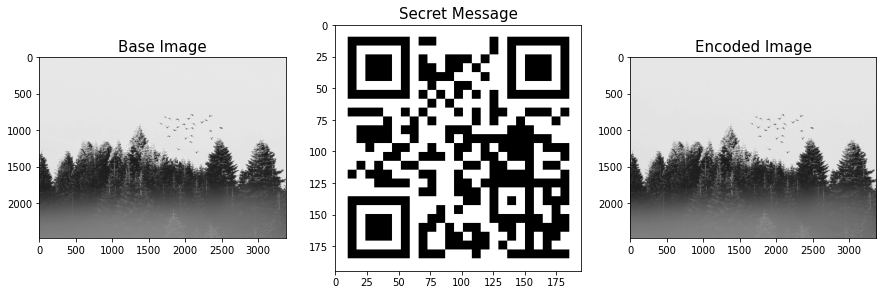

In [4]:
fig, ax = plt.subplots(1,4,figsize=(15,15))
ax[0].set_title('Base Image', fontsize = 15)
ax[0].imshow(imgBaseV, cmap='gray')

ax[1].set_title('Secret Message', fontsize = 15)
ax[1].imshow(imgSecretV, cmap='gray')

encodedImageV = encode(imgBaseV, imgSecretV).real
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV.astype(np.float64)*255

noise = decode(encode(imgBaseV, np.zeros(imgSecretV.shape)+1).real, imgSecretV)

finalImage = np.copy(imgBase)
finalImage[:,:,:3] = convertRGB(encodedImage)
imageio.imsave('./images/encoded.png', finalImage)
ax[2].set_title('Encoded Image', fontsize = 15)
ax[2].imshow(np.clip(encodedImageV.real, 0, 255), cmap='gray')

#encodedImage2 = convertHSV(finalImage)
#print(np.where(np.logical_not(np.isclose(encodedImage, convertHSV(convertRGB(encodedImage))))))
#print(encodedImage - encodedImage2)
#encodedImageV2 = floatV(encodedImage2)
# print(encodedImage)
# print(encodedImage2)
# print(np.where(np.logical_not(np.isclose(encodedImageV, encodedImageV2))))

secret = decode(encodedImageV,imgSecretV).real
imageio.imsave('./images/decoded.png', (normalize(secret.real-noise.real)*255).astype(np.uint8))
ax[3].set_title('Decoded Message', fontsize = 15)
ax[3].imshow(normalize(secret.real-noise.real), cmap='gray')

In [6]:
testimage = convertHSV(convertRGB(encodedImage))
print('where:')
print(np.where(np.logical_not(np.isclose(testimage, encodedImage))))
print('encoded:')
print(encodedImage)
print('test:')
print(testimage)

where:
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
encoded:
[[[6.66666667e-01 8.84955752e-03 2.25027181e+02]
  [6.66666667e-01 8.73362445e-03 2.28232503e+02]
  [6.66666667e-01 8.62068966e-03 2.31107578e+02]
  ...
  [6.66666667e-01 8.65800866e-03 2.30554618e+02]
  [6.66666667e-01 8.62068966e-03 2.30843135e+02]
  [6.66666667e-01 8.62068966e-03 2.30775092e+02]]

 [[6.66666667e-01 8.65800866e-03 2.30764560e+02]
  [6.66666667e-01 8.65800866e-03 2.30282678e+02]
  [6.66666667e-01 8.65800866e-03 2.30210488e+02]
  ...
  [6.66666667e-01 8.65800866e-03 2.30892259e+02]
  [6.66666667e-01 8.65800866e-03 2.30997420e+02]
  [6.66666667e-01 8.65800866e-03 2.31006195e+02]]

 [[6.66666667e-01 8.51063830e-03 2.35745803e+02]
  [6.66666667e-01 8.58369099e-03 2.33524309e+02]
  [6.66666667e-01 8.65800866e-03 2.31575294e+02]
  ...
  [6.66666667e-01 8.65800866e-03 2.31396380e+02]
  [6.66666667e-01 8.65800866e-03 2.31936138e+02]
  [6.66666667e-01 8.65800866e-03 2.31990730e+02]]

 ...


195 195
195 195
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


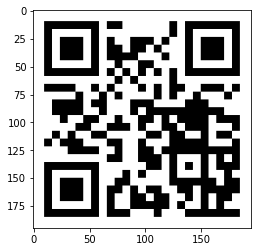

In [13]:
def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return np.fft.fftshift(imgFFT)

def applyIFFT(img):
    imgShift = np.fft.ifftshift(img)
    imgIFFT = np.fft.ifft2(imgShift)
    return imgIFFT

def encode(img1, img2):
    imgBase = applyFFT(np.copy(img1))
    height, width = imgBase.shape
    
    imgSecret = applyFFT(img2)
    imgSecretFlat = imgSecret.flatten()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                #print(ind,x+idx,y+idx)
                ind += 1
            else:
                break
    return applyIFFT(imgBase)

def decode(img1,img2):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    
    secret_h, secret_w = img2.shape
    print(secret_h, secret_w)
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                #print(ind,x+idx,y+idx)
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return applyIFFT(secret)

blankenc = encode(imgBaseV, np.zeros(imgSecretV.shape)+1)
blankdec = decode(blankenc.real, np.zeros(imgSecretV.shape)+1).real

testenc = encode(imgBaseV, imgSecretV)
# print()
# print()
# print()
testdec = decode(testenc.real, imgSecretV)
plt.imshow(testdec.real-blankdec.real, cmap='gray')
print(normalize(testdec.real-blankdec.real))

# import imageio
# imageio.imwrite('output.png', (normalize(testdec.real-blankdec.real)*255).astype(np.uint8))

# test = applyFFT(applyIFFT(imgSecretV))
# plt.imshow(abs(test), cmap='gray')
# print(abs(test))

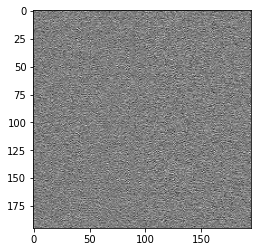

In [14]:
plt.imshow(blankdec, cmap='gray')